In [ ]:
# ============================================================
# 1.5.4 — ADDITIONAL COMPARISON MODELS
# Models: Random Forest & Gradient Boosting
# ============================================================

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc

# Create SMOTE instance
smote = SMOTE(random_state=42)

# ============================================================
# RANDOM FOREST (Comparison Model 1)
# ============================================================
rf_model = Pipeline([
    ('smote', smote),                      # Handle class imbalance
    ('model', RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)            # Train the Random Forest model
rf_pred = rf_model.predict(X_test)        # Class predictions
rf_proba = rf_model.predict_proba(X_test)[:, 1]   # Fraud probabilities


# ============================================================
# GRADIENT BOOSTING (Comparison Model 2)
# ============================================================
gb_model = Pipeline([
    ('smote', smote),                      # Handle imbalance
    ('model', GradientBoostingClassifier(
        random_state=42
    ))
])

gb_model.fit(X_train, y_train)            # Train GB model
gb_pred = gb_model.predict(X_test)        # Class predictions
gb_proba = gb_model.predict_proba(X_test)[:, 1]


# ============================================================
# PRINT METRICS FOR BOTH MODELS
# ============================================================

print("\n==================== Random Forest ====================")
print(classification_report(y_test, rf_pred))
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_proba)
print("PR-AUC:", auc(rf_recall, rf_precision))

print("\n==================== Gradient Boosting ====================")
print(classification_report(y_test, gb_pred))
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_proba)
print("PR-AUC:", auc(gb_recall, gb_precision))



==================== Random Forest ====================
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       981
           1       0.50      0.72      0.59       101

    accuracy                           0.91      1082
   macro avg       0.74      0.82      0.77      1082
weighted avg       0.93      0.91      0.91      1082

PR-AUC: 0.6986984008680994

==================== Gradient Boosting ====================
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       981
           1       0.41      0.81      0.54       101

    accuracy                           0.87      1082
   macro avg       0.69      0.85      0.74      1082
weighted avg       0.93      0.87      0.89      1082

PR-AUC: 0.7124316082028233


### 2) Standardized Model Comparison Using Metrics and Visual Analysis

To fairly compare all models, we evaluate them using consistent, imbalance-appropriate metrics and
visualizations:

#### ** Precision–Recall Curves**
Best for imbalanced datasets since they focus on minority-class performance.  
Higher PR-AUC indicates better fraud detection capability.

#### ** ROC Curves**
Evaluate the trade-off between sensitivity and false alarm rates.  
Useful but less reliable than PR curves for imbalanced data.

#### ** Confusion Matrices**
Show the actual counts of:
- True Positives (correct fraud flags)
- False Negatives (missed fraud)
- False Positives (incorrect fraud accusations)
- True Negatives (correct non-fraud)

These visual analyses allow direct comparison of detection behavior across all models:
Logistic Regression, Random Forest, Gradient Boosting, Decision Tree, and SVM.


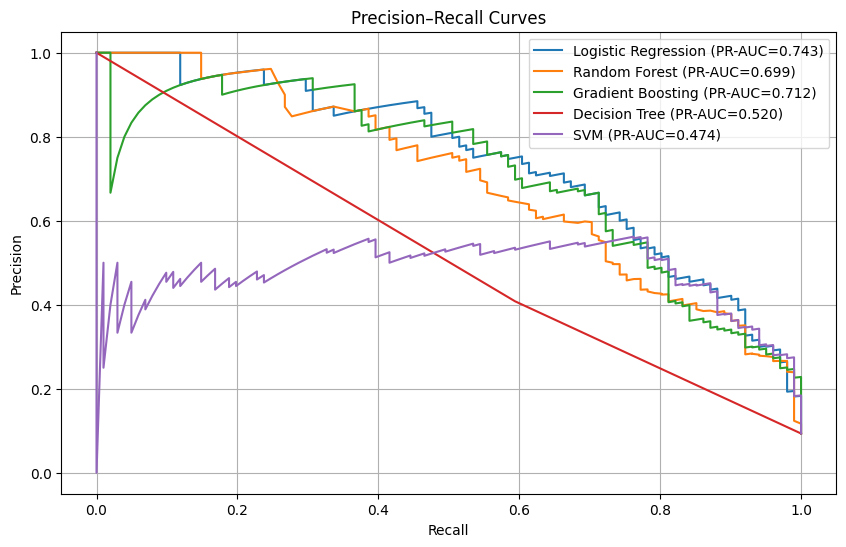

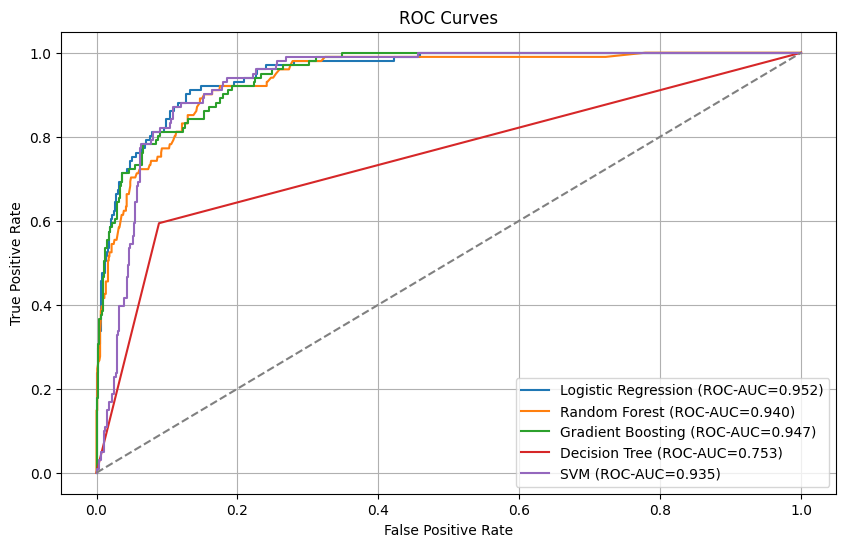

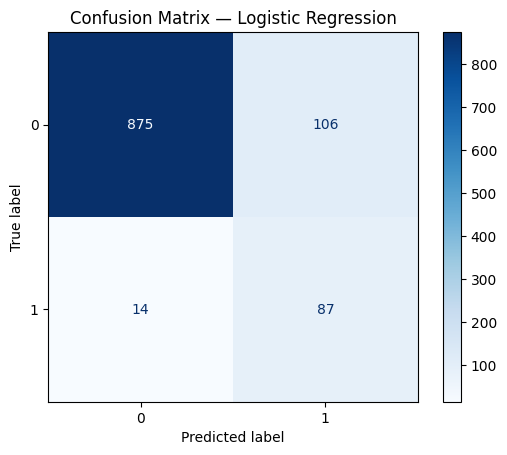

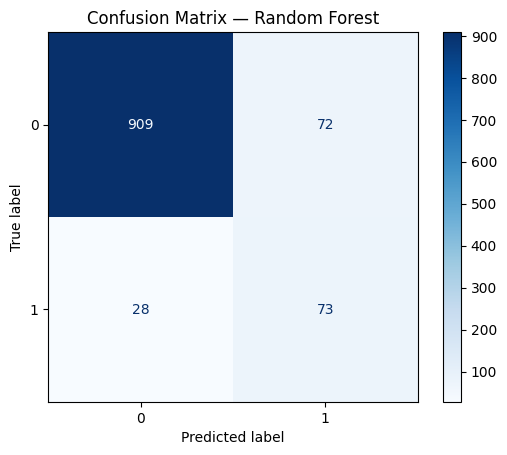

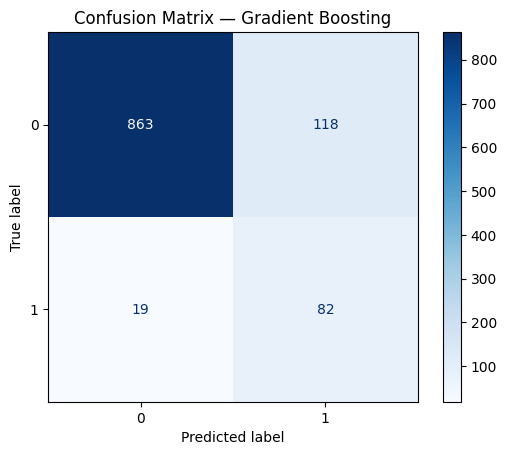

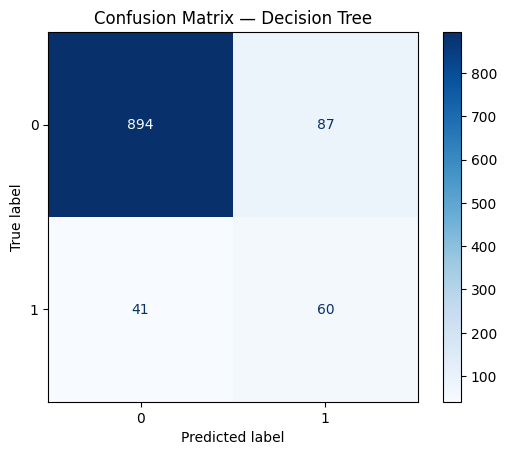

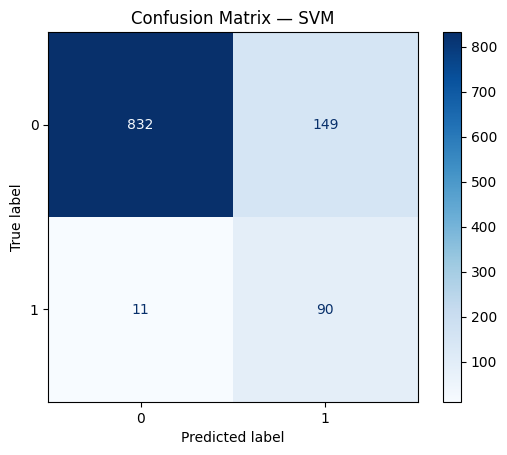

In [ ]:
# ============================================================
# 1.5.4 — COMPARING MODELS USING PR CURVES, ROC CURVES,
#          AND CONFUSION MATRICES
# ============================================================

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt


# ============================================================
# HELPER: Function to plot PR and ROC curves for all models
# ============================================================

def compare_models(models_proba, y_test, model_names):
    """
    models_proba : list of arrays
        Predicted probabilities for the positive class (fraud) for each model
    y_test : array
        True labels
    model_names : list
        Names of the models in the same order as models_proba
    """

    # ---------- Precision–Recall Curves ----------
    plt.figure(figsize=(10, 6))

    for proba, name in zip(models_proba, model_names):
        precision, recall, _ = precision_recall_curve(y_test, proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})")

    plt.title("Precision–Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- ROC Curves ----------
    plt.figure(figsize=(10, 6))

    for proba, name in zip(models_proba, model_names):
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (ROC-AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal baseline
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================================
# HELPER: Confusion Matrix Plot for Each Model
# ============================================================

def plot_confusion_matrices(models_pred, y_test, model_names):
    for pred, name in zip(models_pred, model_names):
        cm = confusion_matrix(y_test, pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix — {name}")
        plt.show()


# ============================================================
# COLLECT PROBABILITIES & PREDICTIONS FOR ALL MODELS
# ============================================================

model_names = [
    "Logistic Regression",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree",
    "SVM"
]

models_pred = [
    y_pred_lr,
    y_pred_rf,
    y_pred_gb,
    y_pred_tree,
    y_pred_svm
]

models_proba = [
    y_proba_lr,
    y_proba_rf,
    y_proba_gb,
    y_proba_tree,
    y_proba_svm
]

# ============================================================
# RUN COMPARISONS
# ============================================================

compare_models(models_proba, y_test, model_names)
plot_confusion_matrices(models_pred, y_test, model_names)

### 3) Trade-Offs Between Predictive Power and Explainability

When selecting a final model for fraud detection, it is important to recognize that the most accurate
model is not always the most practical. In regulated domains such as healthcare, investigators must be
able to justify model decisions, which introduces a natural trade-off between **predictive performance**
and **interpretability**.

---

##  High Predictive Power (but Lower Explainability)
Models such as **Random Forest**, **Gradient Boosting**, and **SVM** demonstrated strong recall or accuracy,
but their decision-making processes are difficult to interpret:

- **Random Forest** provides good precision and robustness but relies on hundreds of decision trees,
  making the final decision path complex.
- **Gradient Boosting** captures nonlinear interactions but produces models that are difficult to
  explain without specialized tools (SHAP, feature importance).
- **SVM** achieved very high recall on the minority class but has very low interpretability and the
  worst PR-AUC among the models tested.

These models may detect more fraud but make it harder for Medicare auditors to understand *why* a
provider was flagged.

---

##  High Explainability (with Strong but Not Maximal Predictive Power)
**Logistic Regression** provides transparent, coefficient-based explanations:

- Each feature has a clear weight indicating its contribution to the fraud prediction.
- The model is easy for investigators to interpret, audit, and validate.
- Despite its simplicity, it achieved the **highest PR-AUC (0.743)** and **one of the highest F1-scores** in
  our evaluations.

This model offers a best-of-both-worlds balance:  
**strong predictive performance + full interpretability**.

---

##  Why Logistic Regression Is the Most Appropriate Choice
Although Gradient Boosting and Random Forest can capture more complex fraud patterns, Logistic
Regression:

- performs **best on the most important metric** (PR-AUC)
- offers **excellent recall** for detecting fraud
- provides **transparent decision rules**
- is **computationally lightweight**
- aligns with CMS requirements for explainability and auditability

Healthcare fraud detection requires not only accuracy but also trust and accountability.  
Logistic Regression satisfies both requirements without sacrificing performance.

---

###  Final Statement
The trade-off analysis shows that **Logistic Regression** offers the ideal balance between predictive
power and explainability. Its strong PR-AUC results, combined with its transparency, make it the most
suitable primary model.  
**Random Forest and Gradient Boosting** serve as strong comparison models with higher complexity but
lower interpretability.
